## Objective:

- plot the points using the vertices by using geo-location information
- - PATCHES: polygon shape values by pre-processing from the CORNER points of the OCO data: vertex_longitude, and vertex_latitude
- This patches values can create POLYGON shape visualization providing more accurate coverage
- with the geo-location information provided from GEOPY library, we can plot the desired
location with BASEMAP library
- BEST suitable for local coverage region

#### Library: geopy: provides geo-location information with LOCATION as string passed
- EG: loc= geopy.geocoders.Nominatim(user_agent='find_location')
    loc.geocode('Los Angeles, USA').raw  // for full raw information

In [2]:
# !pip install geopy

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim

from pyarrow import parquet as parq
import pyarrow as pa

In [13]:
import pandas as pd
from mpl_toolkits.basemap import Basemap
import os
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl

from matplotlib.collections import PatchCollection
#import cartopy
import pydeck as pdk

In [4]:
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Example: 
- Retrieving the geo-locaiton information

In [5]:
## test
geo_loc= Nominatim(user_agent="locate")
new_loc= geo_loc.geocode("Los Angeles").raw
new_loc

{'place_id': 355412804,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'relation',
 'osm_id': 207359,
 'boundingbox': ['33.659541', '34.337306', '-118.6681779', '-118.1552947'],
 'lat': '34.0536909',
 'lon': '-118.242766',
 'display_name': 'Los Angeles, Los Angeles County, CAL Fire Contract Counties, California, United States',
 'class': 'boundary',
 'type': 'administrative',
 'importance': 0.9738053728457621,
 'icon': 'https://nominatim.openstreetmap.org/ui/mapicons/poi_boundary_administrative.p.20.png'}

In [6]:
new_loc['boundingbox']

['33.659541', '34.337306', '-118.6681779', '-118.1552947']

## Function:
- Retrieving the patches: polygon shape values retrieved from the CORNER points of the data: vertex_longitude, and vertex_latitude

In [9]:
def get_patches(path_, season):

    all_files = glob.glob(os.path.join(path_, "*.csv"))
    df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
    
    months= ['Jan', 'Feb', 'March','April','May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
    months_num= np.arange(1, 13).tolist()
    
    ## XCO2 total values
    xco2_total= np.array(df['Xco2'][:])

    ## FUNCTION to split the brackets
    def split_bracket(d):
        l = [float(x.strip(' []')) for x in d.split(',')]
        return l

    ## pre-processing the vertices as LIST, if it has EXTRA brackets
    df["Longitude_vertices"]=df["Longitude_vertices"].apply(split_bracket)
    df["Latitude_vertices"]=df["Latitude_vertices"].apply(split_bracket)

    ## Coverage by different seasons
    spring= np.arange(3, 6)
    fall= np.arange(9, 12)
    
    if str(season) == "spring":
        df= df[df["Month"].isin(spring)]
        months_selected= spring
    elif str(season) == "fall":
        df= df[df["Month"].isin(fall)]
        months_selected= fall
        
    # reset the index if required
    df= df.reset_index()
    df= df.drop(columns=['index'])
    
    # DSTACK the vertices together
    # vertices features comes from OCO data which are corner points; vertex latitude and vertex longitude
    flat_vert=[]
    for j in range(len(df)):
        flat_vert.append(np.dstack([ np.array(df['Longitude_vertices'][j]), np.array(df['Latitude_vertices'][j]) ]))

    # flat_verterices SHAPE from MULTI-dimensional shape
    unpack_vert= [element for sublist in flat_vert for element in sublist]

    ## Combined the polygon patches total
    # POLYGONS for matplotlib
    patches_total= [mpatches.Polygon(row) for row in unpack_vert ]

#     for row in unpack_vert:
#         polygon= mpatches.Polygon(row)
#         patches_total.append(polygon)    

#    df_months= df["Month"].unique()
        
    return patches_total, xco2_total, [months[m] for m in months_selected]

## Basemap Functions to PLOT the data
1. visualize the targetted location
2. visualize by zooming out the targetted location

## 1. 

In [20]:
# %matplotlib notebook
#unpack_vert= unpack_vert[:65000]
def plot_by_vertices(llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat,
                 patches_total, xco2_total, year, months_sel):
    fig= plt.figure(111)
    ax= fig.add_subplot(111)

    xco2_min_= 405
    xco2_max_= 420

    # ###worldmap (FULL_OUTER_MAP)
#     m= Basemap(projection= 'cyl',
#             llcrnrlon= -125,
#             urcrnrlon= -114.37,
#             llcrnrlat= 32.27,
#             urcrnrlat= 42.2514,
#             resolution='l', 
#             epsg= 4269
#             )

    # ###worldmap (FULL_OUTER_MAP)
    m= Basemap(projection= 'cyl',
            llcrnrlon= llcrnrlon,
            urcrnrlon= urcrnrlon,
            llcrnrlat= llcrnrlat,
            urcrnrlat= urcrnrlat,   
            resolution='l', 
            epsg= 4269
            )

    m.arcgisimage(server='http://server.arcgisonline.com/ArcGIS', 
                  #service='World_Shaded_Relief', 
                  service='World_Imagery',
                  xpixels=800, ypixels=None, dpi= 1000, verbose=False)

    # DARK backgroudn
#     m.fillcontinents(color='#2d2d2d',lake_color='#000000')
#     # black background
#     m.drawmapboundary(fill_color='#000000')
    
    cmap= plt.get_cmap('viridis')
    colors= cmap(xco2_total)

    ## normalize
    norm= matplotlib.colors.Normalize(vmin= xco2_min_,
                                     vmax= xco2_max_)

    ## patch collection and plt show
    p= PatchCollection(patches_total,
                       cmap= matplotlib.cm.viridis, 
                       #alpha= 0.95, 
                      # linewidths= 4
                       edgecolor='none',
                       norm= norm
                      )

    # set color range from XCO2
    #p.set_color(colors)
    p.set_array(xco2_total)
    #p.set_clim(np.min(xco2), np.max(xco2))

    plt.gcf().set_size_inches(10, 10)
    ax.add_collection(p)

    ## COLOR bar
    cmap = mpl.cm.viridis
    norm = mpl.colors.Normalize(vmin=405, vmax=420)
    
    
    cbar= plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                 #cax=ax, 
                       orientation='horizontal', label='OCO3 and OCO2, XCO2 ppm\nMonths: '+ str(months_sel))
#    plt.savefig('dark'+str(year)+'_'+str(months_sel)+"_oco2_oco3_comb.jpg", dpi= 3500, bbox_inches='tight', pad_inches= 2)
    plt.show();

## 2. 

In [10]:
# %matplotlib notebook
# #unpack_vert= unpack_vert[:65000]
#def plot_monthly(patches_total, xco2_total, year, month, months_sel):

def plot_monthly(llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat):
    fig= plt.figure(111)
    ax= fig.add_subplot(111)

    xco2_min_= 405
    xco2_max_= 420

    # ###worldmap (FULL_OUTER_MAP)
    m= Basemap(projection= 'cyl',
            llcrnrlon= llcrnrlon,
            urcrnrlon= urcrnrlon,
            llcrnrlat= llcrnrlat,
            urcrnrlat= urcrnrlat,   
            resolution='l', 
            epsg= 4269
            )
    m.arcgisimage(server='http://server.arcgisonline.com/ArcGIS', 
                  #service='World_Shaded_Relief', 
                  service='World_Imagery',
                  xpixels=4000, ypixels=None, dpi= 3500, verbose=False)

    cmap= plt.get_cmap('viridis')
#     colors= cmap(xco2_total)

    plt.gcf().set_size_inches(10, 10)
    plt.show();

## 3

In [21]:
def get_patches_parq(df, season):

#     all_files = glob.glob(os.path.join(path_, "*.csv"))
#     df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
    
    
    months= ['Jan', 'Feb', 'March','April','May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
    months_num= np.arange(1, 13).tolist()
    
    ## XCO2 total values
    xco2_total= np.array(df['Xco2'][:])

    ## FUNCTION to split the brackets
#     def split_bracket(d):
#         l = [float(x.strip(' []')) for x in d.split(',')]
#         return l

#     ## pre-processing the vertices columnx
#     df["Longitude_vertices"]=df["Longitude_vertices"].apply(split_bracket)
#     df["Latitude_vertices"]=df["Latitude_vertices"].apply(split_bracket)

    spring= np.arange(3, 6)
    fall= np.arange(9, 12)
   
   
    ## Select months by different seasons
    ## Pass season by string to attach on colorbar
    if str(season) == "spring":
        df= df[df["Month"].isin(spring)]
        months_selected= spring
    elif str(season) == "fall":
        df= df[df["Month"].isin(fall)]
        months_selected= fall
        
        
    # reset the index
    df= df.reset_index()
    df= df.drop(columns=['index'])
    
    # DSTACK the vertices together
    flat_vert=[]
    for j in range(len(df)):
        flat_vert.append(np.dstack([ np.array(df['Longitude_vertices'][j]), np.array(df['Latitude_vertices'][j]) ]))

    # flat_verterices SHAPE from MULTI-dimensional shape
    unpack_vert= [element for sublist in flat_vert for element in sublist]

    ## Combined the polygon patches total
    # POLYGONS for matplotlib
    patches_total= []

    for row in unpack_vert:
        polygon= mpatches.Polygon(row)
        patches_total.append(polygon)

    df_months= df["Month"].unique()
        
    return patches_total, xco2_total, [months[m] for m in months_selected]

### CLASS objectivte:
- with the geo-location information provided from GEOPY library
- Using the variable <b>Bounding Box</b> to locate the region

In [14]:
class get_location():

    def __init__(self, n):
        self.name= str(n)
        
    def get_info(self, name):
        self.info= geo_loc.geocode(str(self.name)).raw
        
        if self.info: 
            return self.info
        else:
            raise ValueError('No location information, Please re-enter!')
    
    # get bounding box
    def get_bb(self, n):
        self.bbx= self.info["boundingbox"]
        self.bbx_list= [float(i) for i in self.bbx]
        
        # Get the bounding box coordinates
        self.a= self.bbx_list[0]
        self.b= self.bbx_list[1]
        self.c= self.bbx_list[2]
        self.d= self.bbx_list[3]
        
        return self.bbx_list
    
    # Get Geo-location information
    def get_location_info(self):
        return self.info["display_name"]
    
    ##################################################################    
    # EACH coordinates are the corner points of the bounding box information retrieved from geopy package
    # Order of params (a,b,c,d) can be re-ordered
    ##################################################################    
    def get_map(self):    
    
        return plot_monthly(self.c, self.d, self.a, self.b)
    
    ##################################################################
    # plot outside of the region; ZOOMED out Frame
    # By increasing the bounding box size
    ##################################################################
    def plot_outside(self, points):
        self.points= points
        self.extra= 2
        return plot_monthly(self.c - points - self.extra, self.d + points + self.extra,
                            self.a - points - self.extra, self.b + points + self.extra)
        
    ##################################################################
    ## get Patches from the dataframe
    # PATCHES are the POLYGON shaped values which will be used for plotting with vertices
    ##################################################################
    def get_patches(self, path, season):
        self.patches_total, self.xco2_total, self.months_sel= get_patches(path, str(season))

    ##plot the data by passing the BOUNDING box information, patches, xco2_values
    def plot_data(self, year):
        return plot_by_vertices(self.c, self.d, self.a, self.b, self.patches_total, self.xco2_total,str(year), self.months_sel)
        
    ##################################################################
    # get patches from PARQUET data
    # FILTER the data and pass to the `plot`
    ##################################################################
    def get_patches_parq(self, data, season):
        ## filter the data by co-ordinates
        self.df= data
        
        # Passing the values of bounding box into basemap function
        # We can Re- Arrange the location of corner points here,
        # a, b, c, d (llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat)
        # EG: California's bbx; [32.5295236, 42.009499, -124.482003, -114.1307816]
        self.df_first= self.df[(self.df['Latitude'] < self.b ) & (self.df['Latitude'] > self.a)]
        self.df_second= self.df_first[(self.df_first['Longitude'] > self.c) &(self.df_first['Longitude'] < self.d)]
        
#         self.patches_parq, self.xco2_total_parq, self.months_sel_parq= get_patches_parq(data, str(season))
        self.patches_parq, self.xco2_total_parq, self.months_sel_parq= get_patches_parq(self.df_second, str(season))
    

    def plot_data(self, year):
        return plot_by_vertices(self.c - self.points/2 , self.d + self.points/2, self.a - self.points/2, self.b + self.points/2,
                                self.patches_parq, self.xco2_total_parq, str(year), self.months_sel_parq)
 

Enter the location(city/country):
los angeles
***********************************

Location:

los angeles

Geo-location information:

{'place_id': 355412804, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 207359, 'boundingbox': ['33.659541', '34.337306', '-118.6681779', '-118.1552947'], 'lat': '34.0536909', 'lon': '-118.242766', 'display_name': 'Los Angeles, Los Angeles County, CAL Fire Contract Counties, California, United States', 'class': 'boundary', 'type': 'administrative', 'importance': 0.9738053728457621, 'icon': 'https://nominatim.openstreetmap.org/ui/mapicons/poi_boundary_administrative.p.20.png'}
***********************************

Bounding Box info:

[33.659541, 34.337306, -118.6681779, -118.1552947]
***********************************

Outer map extending bbx by 3 points 



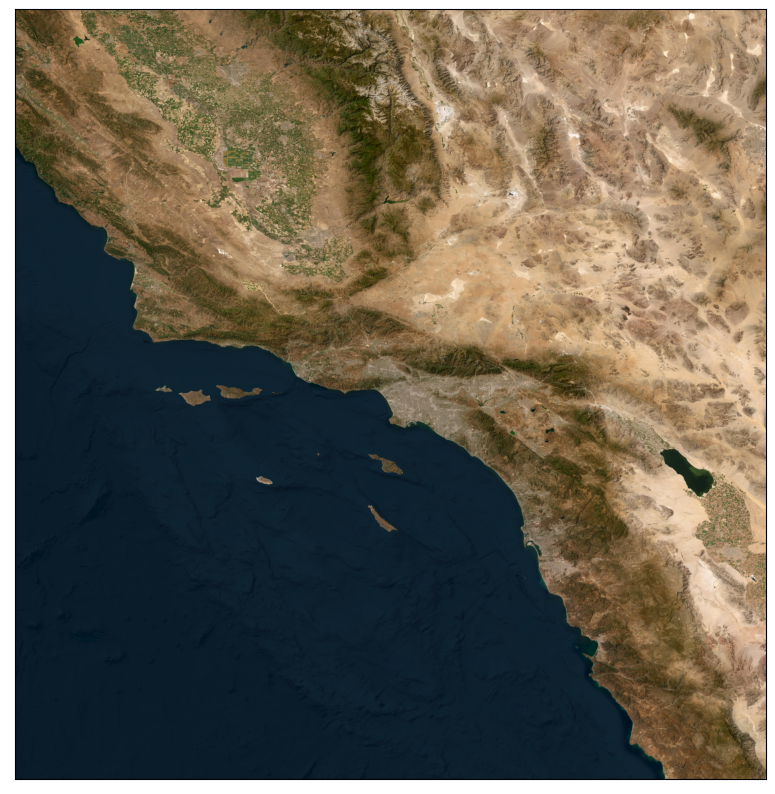

***********************************

Displaying the map; Zoom In



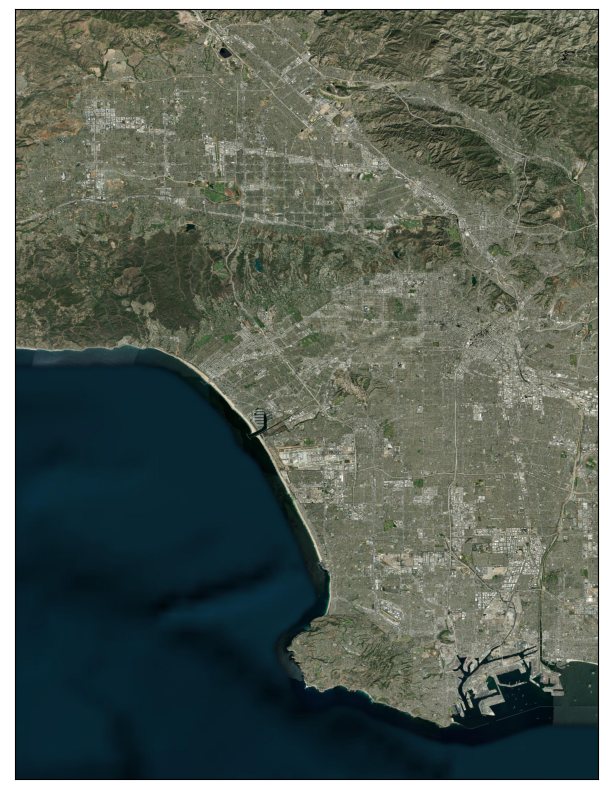

In [15]:
print("Enter the location(city/country):")
Enter_loc= input()

find_loc= get_location(Enter_loc)

print('***********************************\n')
print('Location:\n')
print(find_loc.name)

print("\nGeo-location information:\n")
print(find_loc.get_info(Enter_loc))

print('***********************************\n')
print('Bounding Box info:\n')
print(find_loc.get_bb(Enter_loc))

print('***********************************\n')
print('Outer map extending bbx by 3 points \n')
find_loc.plot_outside(1)

print('***********************************\n')
print('Displaying the map; Zoom In\n')
find_loc.get_map()

## READ PARQUET FILE
- pre-processed and compressed parquet file from the func:

In [16]:
%%time
df_parq_oco3= pd.read_parquet("../Parquet_format_oco2_oco3/new_oco3_2020_parquet_dateTime_reformated.parquet", engine="pyarrow")

Wall time: 16.3 s


Enter the location(city/country):
los angeles
***********************************

Location:

los angeles

Geo-location information:

{'place_id': 355412804, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 207359, 'boundingbox': ['33.659541', '34.337306', '-118.6681779', '-118.1552947'], 'lat': '34.0536909', 'lon': '-118.242766', 'display_name': 'Los Angeles, Los Angeles County, CAL Fire Contract Counties, California, United States', 'class': 'boundary', 'type': 'administrative', 'importance': 0.9738053728457621, 'icon': 'https://nominatim.openstreetmap.org/ui/mapicons/poi_boundary_administrative.p.20.png'}
***********************************

Geo-Location info:

Los Angeles, Los Angeles County, CAL Fire Contract Counties, California, United States
***********************************

Bounding Box info:

[33.659541, 34.337306, -118.6681779, -118.1552947]
***********************************

Outer map by 3 points 



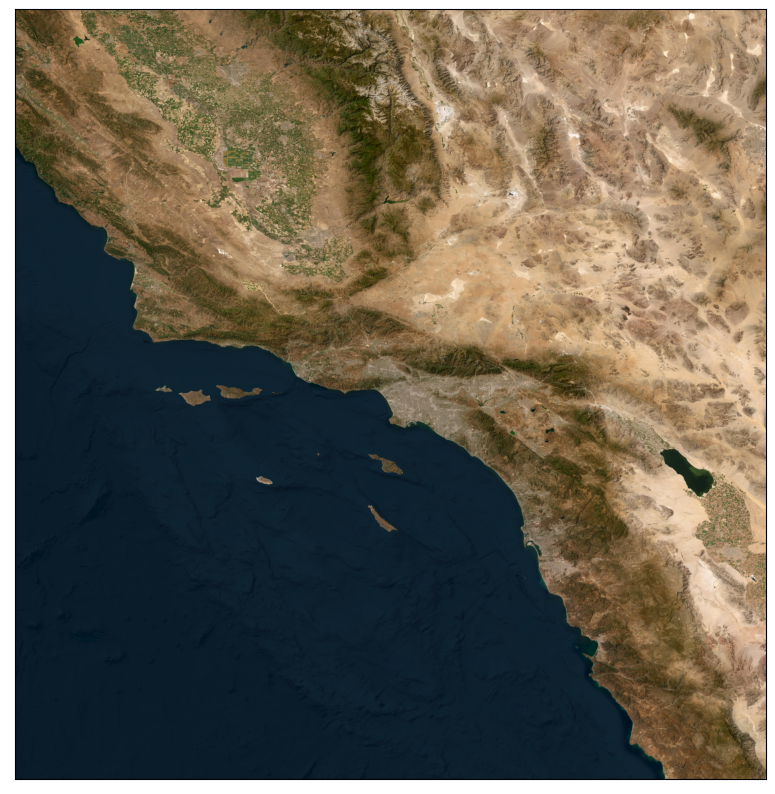

***********************************

***********************************

Displaying the map



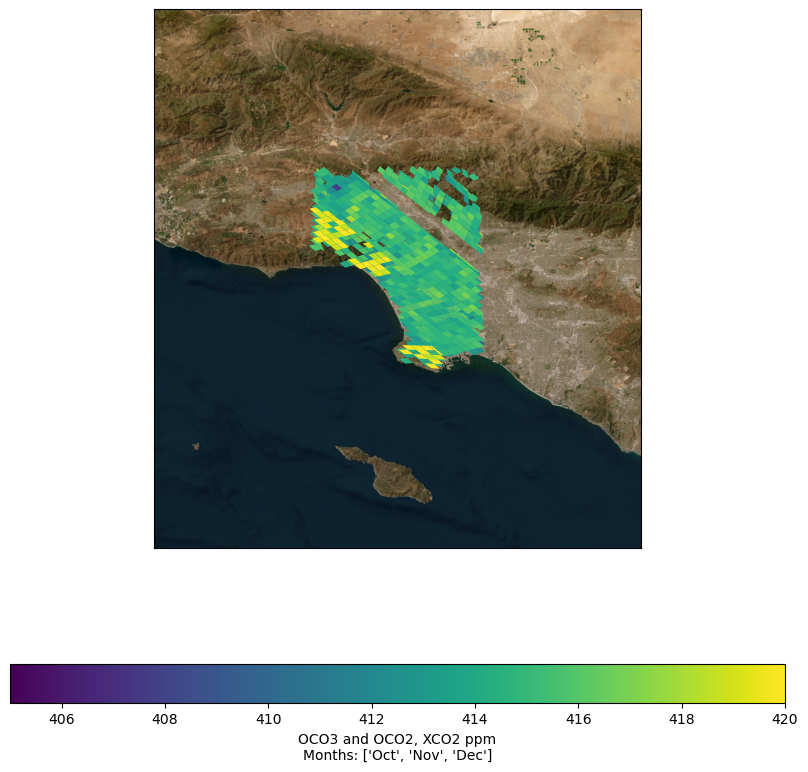

Wall time: 36.7 s


In [23]:
%%time
print("Enter the location(city/country):")
Enter_loc= input()

find_loc= get_location(Enter_loc)

print('***********************************\n')
print('Location:\n')
print(find_loc.name)

print("\nGeo-location information:\n")
print(find_loc.get_info(Enter_loc))

print('***********************************\n')
print('Geo-Location info:\n')
print(find_loc.get_location_info())

print('***********************************\n')
print('Bounding Box info:\n')
print(find_loc.get_bb(Enter_loc))

print('***********************************\n')
print('Outer map by 3 points \n')
find_loc.plot_outside(1)

print('***********************************\n')
find_loc.get_patches_parq(df_parq_oco3, "fall")

# print('***********************************\n')
# find_loc.get_patches_parq(df_parq_test, "fall")

print('***********************************\n')
print('Displaying the map\n')
find_loc.plot_data( 2020)